# HSC Amp-to-Amp Offsets

## Useful links
* [LSKs GitHub Repo](https://github.com/leeskelvin/amp2amp)
* [Jira Ticket (DM-20303)](https://jira.lsstcorp.org/browse/DM-20303)
* [Dropbox paper: Background Exploration Aug 2018](https://paper.dropbox.com/doc/Background-Exploration-Aug-2018--ApTKzYDGr98X1Dl_UXBp5iGGAg-62Gc0Msel3yCa6VEtRVy7)
* [Eli's original analysis code](https://raw.githubusercontent.com/leeskelvin/amp2amp/master/ref/compute_and_plot_amp_offsets_pdr1_perpix4.py)
* [Eli's presentation: HSC Background Offsets: What's Up With That?](https://github.com/leeskelvin/amp2amp/blob/master/ref/hsc_background_offsets.pdf)
* [Boone et al. 2018](https://github.com/leeskelvin/amp2amp/blob/master/ref/Boone2018::2018PASP..130f4504B.pdf)

In [1]:
# output options
ccd = 43
outdir = 'singleccd'

# band selection [all|g|r|i|z|y]
band = 'all'
if band == 'all':
    bandname = 'grizy'
else:
    bandname = band

<h2>Layout of 116 CCD chips on the HSC focal plane</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://ui.adsabs.harvard.edu/abs/2018PASJ...70S...4A/abstract">Aihara et al. 2018</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="ref/aihara2018a.png" alt="Layout of 116 CCD chips on the HSC focal plane"></div>

<h2>HSC CCD Arrangement</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://subarutelescope.org/Observing/Instruments/HSC/ccd.html">https://subarutelescope.org/Observing/Instruments/HSC/ccd.html</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="ref/CCDPosition_20170212.png" alt="HSC CCDs"></div>

<h2>Format of 1 CCD</h2>
<h3 style="margin-top:10px; margin-bottom:25px;"><a href="https://hsc.mtk.nao.ac.jp/pipedoc_5_e/hsc_info_e/index.html">https://hsc.mtk.nao.ac.jp/pipedoc_5_e/hsc_info_e/index.html</a></h3>
<div style="width:700px; height:525px;"><img style="max-width:100%; max-height:100%;" src="ref/Formatof1CCD.png" alt="Format of 1 CCD"></div>

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import astropy.io.fits as fits
import esutil
import os.path
from astropy.time import Time

import lsst.afw.math as afwMath
import lsst.daf.persistence as dafPersist

In [3]:
# setup
if (not os.path.exists(outdir)):
    os.mkdir(outdir)

In [4]:
# butler
butlerVisit = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/fgcm_pdr1_run1wd/wide_deep2'
)
obsTable = butlerVisit.get(
    'fgcmVisitCatalog'
)
butler = dafPersist.Butler(
    '/datasets/hsc/repo/rerun/private/erykoff/hscproc/runIsrPDR1'
)

In [5]:
# define amps
camera = butler.get('camera')
det = camera[ccd]
amp1, amp2, amp3, amp4 = det.getAmplifiers()

In [6]:
# raw data bounding boxes
dbox1 = amp1.getRawDataBBox()
dbox2 = amp2.getRawDataBBox()
dbox3 = amp3.getRawDataBBox()
dbox4 = amp4.getRawDataBBox()

In [7]:
# horizontal overscan bounding boxes
obox1 = amp1.getRawHorizontalOverscanBBox()
obox2 = amp2.getRawHorizontalOverscanBBox()
obox3 = amp3.getRawHorizontalOverscanBBox()
obox4 = amp4.getRawHorizontalOverscanBBox()

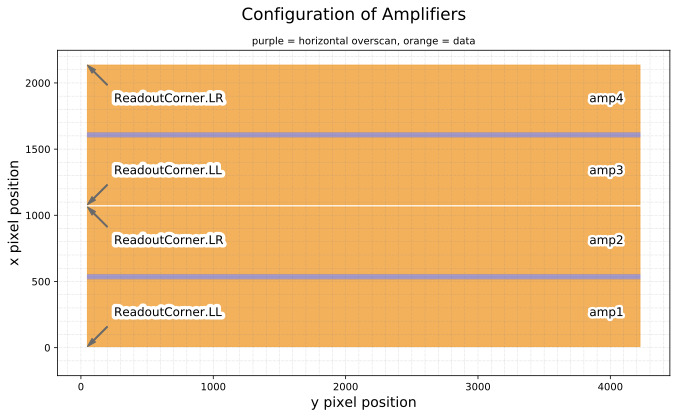

In [8]:
# bounding box plot #1
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111)
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
plt.axis('equal')
plt.rcParams.update({'font.size': 14})
plt.suptitle('Configuration of Amplifiers')
plt.title('purple = horizontal overscan, orange = data', fontsize=10)
plt.xlabel('y pixel position', fontsize=14)
plt.ylabel('x pixel position', fontsize=14)
#plt.gca().invert_xaxis()

# corners
alldcorners = np.array([dbox1.getCorners(), dbox2.getCorners(), dbox3.getCorners(), dbox4.getCorners()])
allocorners = np.array([obox1.getCorners(), obox2.getCorners(), obox3.getCorners(), obox4.getCorners()])
readcorners = (amp1.getReadoutCorner(), amp2.getReadoutCorner(), amp3.getReadoutCorner(), amp4.getReadoutCorner())
alldcenterx = [dbox1.getCenterX(), dbox2.getCenterX(), dbox3.getCenterX(), dbox4.getCenterX()]

# data loop
xreadcorner = []
arrowindent = 150
xreadcornerindent = []
for dcorners,ocorners,readcorner in zip(alldcorners,allocorners,readcorners):
    # data box
    dx = [i[0] for i in dcorners]
    dy = [i[1] for i in dcorners]
    if(str(readcorner)=="ReadoutCorner.LL"):
        xreadcorner.append(np.min(dx))
        xreadcornerindent.append(np.min(dx)+arrowindent)
    else:
        xreadcorner.append(np.max(dx))
        xreadcornerindent.append(np.max(dx)-arrowindent)
    plt.fill(dy, dx, color='#f1a340', alpha=0.85)
    # overscan box
    ox = [i[0] for i in ocorners]
    oy = [i[1] for i in ocorners]
    plt.fill(oy, ox, color='#998ec3', alpha=0.85)

# readout corners
for x0,y0,x1,y1,lab in zip(xreadcorner,[np.min(dy)]*4,xreadcornerindent,
                           [np.min(dy)+arrowindent]*4,["","","",""]):
    txt = plt.annotate(lab, xy=(y0,x0), xytext=(y1,x1), horizontalalignment="left", color="dimgrey", 
                 arrowprops=dict(color='dimgrey', width=1, headwidth=5, headlength=9))
    #txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# finish up
for pos,lab1,lab2 in zip(alldcenterx,["amp1","amp2","amp3","amp4"],readcorners):
    txt1 = plt.text(x=4100, y=pos, s=lab1, fontsize=12, horizontalalignment="right", verticalalignment="center")
    txt2 = plt.text(x=250, y=pos, s=str(lab2), fontsize=12, horizontalalignment="left", verticalalignment="center")
    txt1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    txt2.set_path_effects([PathEffects.withStroke(linewidth=7, foreground='w')])
step = 100
left, right = plt.xlim() # switch left and right if x-axis flipped above
bottom, top = plt.ylim()
for yy in range(-step,top.astype(np.int64),step):
    plt.axhline(y=yy, color='grey', linestyle='dotted', alpha=0.5, linewidth=0.5)
for xx in range(-step,right.astype(np.int64),step):
    plt.axvline(x=xx, color='grey', linestyle='dotted', alpha=0.5, linewidth=0.5, ymin=0, ymax=1)
plt.show()

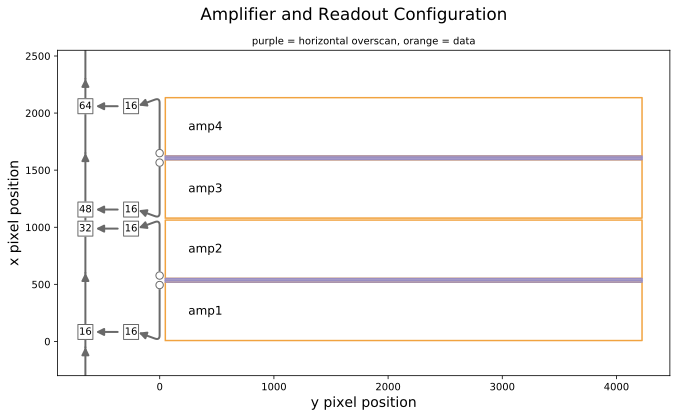

In [9]:
# bounding box plot #2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.figsize'] = (11,5)
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(111)
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
plt.axis('equal')
plt.rcParams.update({'font.size': 14})
plt.suptitle('Amplifier and Readout Configuration')
plt.title('purple = horizontal overscan, orange = data', fontsize=10)
plt.xlabel('y pixel position', fontsize=14)
plt.ylabel('x pixel position', fontsize=14)
#plt.gca().invert_xaxis()

# readout arrows
arrowglobalindent = 50
arrow1indent = 200
arrow1bump = 75
arrow2indent = 300
plt.axvline(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, color='dimgrey', linewidth=2)
ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 2300), 
                                      posB=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 2301), 
                                      arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey")
            )
ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 1650), 
                                      posB=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 1651), 
                                      arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey")
            )
ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 600), 
                                      posB=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, 601), 
                                      arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey")
            )
ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, -51), 
                                      posB=(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, -50), 
                                      arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey")
            )

# geometry values
alldcorners = np.array([dbox1.getCorners(), dbox2.getCorners(), dbox3.getCorners(), dbox4.getCorners()])
allocorners = np.array([obox1.getCorners(), obox2.getCorners(), obox3.getCorners(), obox4.getCorners()])
readcorners = (amp1.getReadoutCorner(), amp2.getReadoutCorner(), amp3.getReadoutCorner(), amp4.getReadoutCorner())
alldcenterx = [dbox1.getCenterX(), dbox2.getCenterX(), dbox3.getCenterX(), dbox4.getCenterX()]

# data loop
for dcorners,ocorners,readcorner,idval in zip(alldcorners,allocorners,readcorners,enumerate(readcorners)):
    # data box
    dx = [i[0] for i in dcorners]
    dy = [i[1] for i in dcorners]
    if(str(readcorner)=="ReadoutCorner.LL"):
        readend = np.min(dx) + arrow1bump
        readangleB = 160
    else:
        readend = np.max(dx) - arrow1bump
        readangleB = 200
    dx.append(dx[0])
    dy.append(dy[0])
    dbbox = plt.plot(dy, dx, color='#f1a340')
    # overscan box
    ox = [i[0] for i in ocorners]
    oy = [i[1] for i in ocorners]
    if(str(readcorner)=="ReadoutCorner.LL"):
        readbegin = np.max(dx) - 25
    else:
        readbegin = np.min(dx) + 25
    ox.append(ox[0])
    oy.append(oy[0])
    obbox = plt.plot(oy, ox, color='#998ec3')
    # readout architecture
    plt.plot(np.min(dy)-arrowglobalindent, readbegin, marker='o', color="white", markersize=7.5, 
             fillstyle="full")
    plt.plot(np.min(dy)-arrowglobalindent, readbegin, marker='o', color="dimgrey", markersize=7.5, 
             fillstyle="none")
    ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent, readbegin), 
                                          posB=(np.min(dy)-arrowglobalindent-arrow1indent, readend), 
                                          arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey", 
                                          connectionstyle=f"angle, angleA=90, angleB={readangleB}, rad=5")
                )
    plt.plot(np.min(dy)-arrowglobalindent-arrow1indent-50, readend, marker='s', color="dimgrey", 
             markersize=15, fillstyle="none")
    plt.text(np.min(dy)-arrowglobalindent-arrow1indent-50, readend, 
             s="16", horizontalalignment="center", verticalalignment="center", fontsize=10)
    ax.add_patch(mpatches.FancyArrowPatch(posA=(np.min(dy)-arrowglobalindent-arrow1indent-150, readend), 
                                          posB=(np.min(dy)-arrowglobalindent-arrow1indent-75-arrow2indent, 
                                                readend), 
                                          arrowstyle="-|>", mutation_scale=15, linewidth=2, color="dimgrey")
                )
    plt.plot(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, readend, marker='s', color="white", 
             markersize=15, fillstyle="full")
    plt.plot(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, readend, marker='s', color="dimgrey", 
             markersize=15, fillstyle="none")
    plt.text(np.min(dy)-arrowglobalindent-arrow1indent-150-arrow2indent, readend, 
             s=f"{16+16*idval[0]}", horizontalalignment="center", verticalalignment="center", fontsize=10)
    
# finish up
for pos,lab1,lab2 in zip(alldcenterx,["amp1","amp2","amp3","amp4"],readcorners):
    plt.text(x=250, y=pos, s=lab1, fontsize=12, horizontalalignment="left", verticalalignment="center")
    #plt.text(x=250, y=pos, s=str(lab2), fontsize=12, horizontalalignment="left", verticalalignment="center")
#step = 100
#left, right = plt.xlim() # switch left and right if x-axis flipped above
#bottom, top = plt.ylim()
#for yy in range(-step,top.astype(np.int64),step):
#    plt.axhline(y=yy, color='grey', linestyle='dotted', alpha=0.5, linewidth=0.5)
#for xx in range(-step,right.astype(np.int64),step):
#    plt.axvline(x=xx, color='grey', linestyle='dott2ed', alpha=0.5, linewidth=0.5, ymin=0, ymax=1)
plt.show()

In [10]:
# obsTable data
filtername = [d['filtername'] for d in np.asarray(obsTable)]
if band != 'all': 
    goodfilters = [i for i,s in enumerate(filtername) if band in s]
    filtername = np.asarray(filtername)[goodfilters]
else: 
    goodfilters = range(len(filtername))
visits = obsTable['visit'][goodfilters]
exptime = obsTable['exptime'][goodfilters]
skybackground = obsTable['skybackground'][goodfilters]
mjd = obsTable['mjd'][goodfilters]
t = Time(mjd, format="mjd")
obsdate = t.decimalyear
ufname,ufcount = np.unique(filtername, return_counts=True)
print('\033[1m')
print('Number of visits:', visits.size)
print('Number of visits by filter:', dict(zip(ufname,ufcount)))
print('Number of pixel rows:', dbox1.getHeight())
print('Exposure time range:', '[', "%.0f" % np.min(exptime), ':', "%.0f" % np.max(exptime), ']')
print('Sky background range:', '[', "%.2f" % np.min(skybackground), ':', "%.2f" % np.max(skybackground), ']')
print('Date of Obs. range:', '[', "%.2f" % np.min(obsdate), ':', "%.2f" % np.max(obsdate), ']')
print('\033[0m')


Number of visits: 5190
Number of visits by filter: {'g': 1030, 'i': 1041, 'r': 925, 'y': 1032, 'z': 1162}
Number of pixel rows: 4176
Exposure time range: [ 30 : 270 ]
Sky background range: [ 56.01 : 14375.22 ]
Date of Obs. range: [ 2014.23 : 2015.87 ]



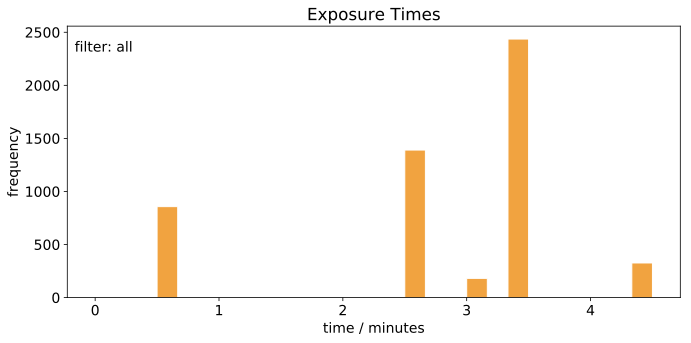

In [11]:
# exposure time histogram
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (11,5)
plt.rcParams.update({'font.size': 14})
plt.title('Exposure Times')
plt.xlabel('time / minutes', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.xticks(np.arange(0, max(exptime) + 60, 60), np.arange(0, (max(exptime) + 60)/60, 1, dtype='i'))
binwidth = 10
plt.hist(exptime, bins=np.arange(0, max(exptime) + binwidth, binwidth), color='#f1a340', edgecolor='white')
plt.annotate('filter: ' + band, xy=(0.15,0.85), xycoords='figure fraction', ha='center')
plt.show()

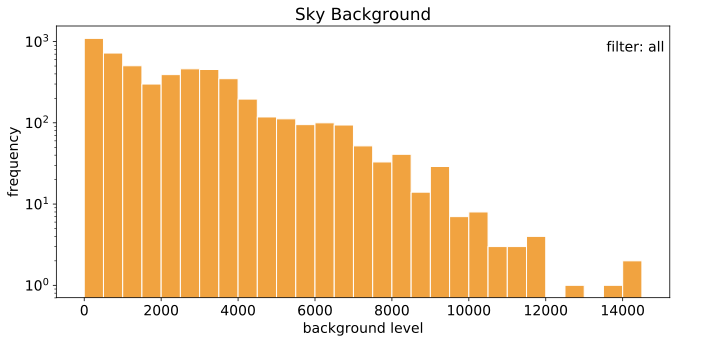

In [12]:
# sky background histogram
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (11,5)
plt.rcParams.update({'font.size': 14})
plt.title('Sky Background')
plt.xlabel('background level', fontsize=14)
plt.ylabel('frequency', fontsize=14)
#plt.xticks(np.arange(0, max(skybackground) + 60, 60), np.arange(0, (max(skybackground) + 60)/60, 1, dtype='i'))
plt.yscale('log', nonposy='clip')
binwidth = 500
plt.hist(skybackground, bins=np.arange(0, max(skybackground) + binwidth, binwidth), color='#f1a340', edgecolor='white')
plt.annotate('filter: ' + band, xy=(0.9,0.85), xycoords='figure fraction', ha='center')
plt.show()

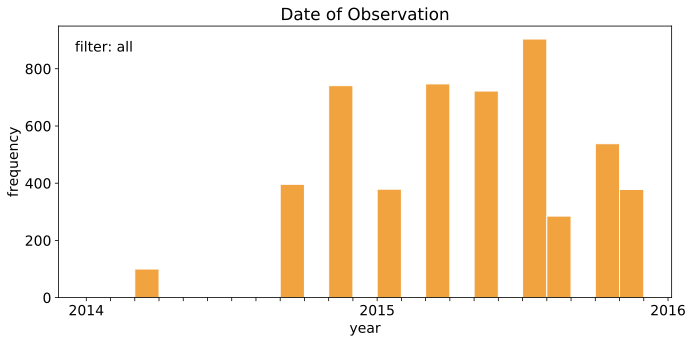

In [13]:
# Modified Julian Date histogram
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (11,5)
plt.rcParams.update({'font.size': 14})
plt.title('Date of Observation')
plt.xlabel('year', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.xticks(ticks=np.arange(2014, 2016+1/12, 1/12), labels=[2014]+[""]*11+[2015]+[""]*11+[2016])
binwidth = 1/12
plt.hist(obsdate, bins=np.arange(2014, max(t.decimalyear) + binwidth, binwidth), 
         color='#f1a340', edgecolor='white')
plt.annotate('filter: ' + band, xy=(0.15,0.85), xycoords='figure fraction', ha='center')
plt.show()

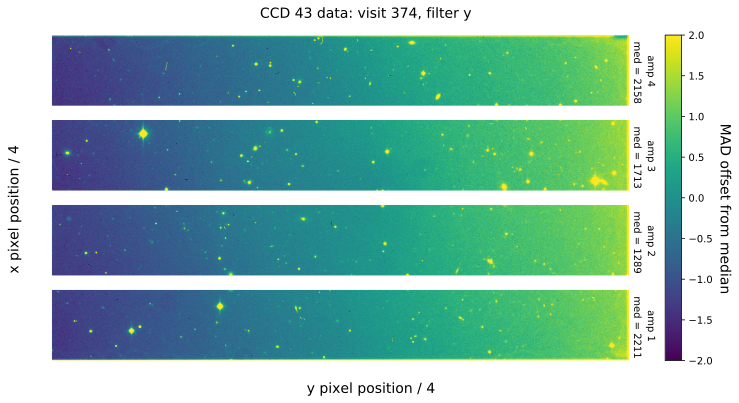

In [14]:
# image of CCD for single visit
%matplotlib inline

# setup
obj = 0 # object of interest
scale = 2 # number of stdevs/madevs to plot either side
imvisit = visits[obj]
imfilter = filtername[obj]

# function to rebin 2D array
def rebin(arr, new_shape):
    shape = (int(new_shape[0]), arr.shape[0] // int(new_shape[0]),
             int(new_shape[1]), arr.shape[1] // int(new_shape[1]))
    return arr.reshape(shape).mean(-1).mean(1)

# median absolute deviation
def mad(x, k = 1.4826):
    return k * np.median(np.abs(x - np.median(x)))

# butler
raw = butler.get('raw', visit=int(imvisit), ccd=ccd)

# get image/mask/variance map for each data region (converted to int64)
data1 = raw.maskedImage[dbox1].getArrays()[0].astype(np.int64)
data2 = raw.maskedImage[dbox2].getArrays()[0].astype(np.int64)
data3 = raw.maskedImage[dbox3].getArrays()[0].astype(np.int64)
data4 = raw.maskedImage[dbox4].getArrays()[0].astype(np.int64)

# rebin, log, subtract mean/median, rescale to std/mad, and rotate
downscale = 4
mdata = []
for data in [data1, data2, data3, data4]:
    md = np.log10(rebin(data, new_shape=tuple(np.array(data.shape)/downscale)))
    #md -= np.mean(md)
    #md /= np.std(md)
    md -= np.median(md)
    md /= mad(md)
    md = np.rot90(md)
    mdata.append(md)

# plotting
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(13,6), dpi=300)
for i, md, ampid, d in zip([0,1,2,3], [mdata[3],mdata[2],mdata[1],mdata[0]], [4,3,2,1], [data4, data3, data2, data1]):
    im = axs[i].imshow(md, vmin=-scale, vmax=scale)
    axs[i].set_axis_off()
    axs[i].text(4296/downscale, 200/downscale, "amp %s" % ampid, rotation=-90)
    axs[i].text(4196/downscale, 100/downscale, "med = %.0f" % np.median(d), rotation=-90)
fig.text(0.35, 0.92, "CCD %s data: visit %s, filter %s" % (ccd, imvisit, imfilter), fontsize=14)
fig.text(0.4, 0.05, "y pixel position / %s" % downscale, fontsize=14)
fig.text(0.08, 0.6, "x pixel position / %s" % downscale, rotation=90, fontsize=14)
fig.text(0.84, 0.65, "MAD offset from median", rotation=-90, fontsize=14)
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

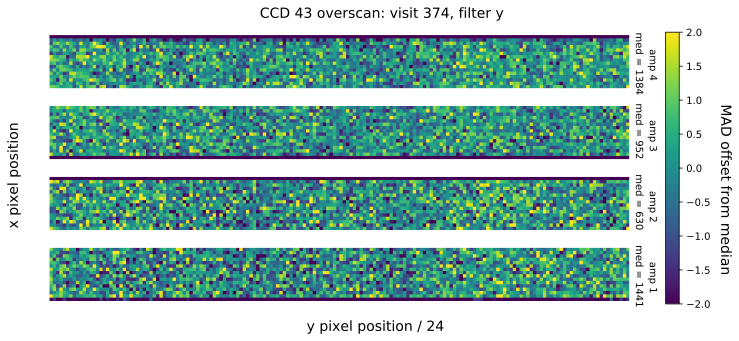

In [15]:
# image of CCD overscan regions for single visit
%matplotlib inline

# setup
obj = 0 # object of interest
scale = 2 # number of stdevs/madevs to plot either side
imvisit = visits[obj]
imfilter = filtername[obj]

# butler
raw = butler.get('raw', visit=int(imvisit), ccd=ccd)

# get image/mask/variance map for each horizontal overscan region (converted to int64)
overscan1 = raw.maskedImage[obox1].getArrays()[0].astype(np.int64)
overscan2 = raw.maskedImage[obox2].getArrays()[0].astype(np.int64)
overscan3 = raw.maskedImage[obox3].getArrays()[0].astype(np.int64)
overscan4 = raw.maskedImage[obox4].getArrays()[0].astype(np.int64)

# rebin, log, subtract mean/median, rescale to std/mad, and rotate
downscale = 24
moverscan = []
for overscan in [overscan1, overscan2, overscan3, overscan4]:
    md = np.log10(rebin(overscan, new_shape=(np.array(overscan.shape)[0]/downscale, 
                                             np.array(overscan.shape)[1])
                       )
                 )
    #md -= np.mean(md)
    #md /= np.std(md)
    md -= np.median(md)
    md /= mad(md)
    md = np.rot90(md)
    moverscan.append(md)

# plotting
fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(13,5), dpi=300)
for i, md, ampid, d in zip([0,1,2,3], [moverscan[3],moverscan[2],moverscan[1],moverscan[0]], 
                           [4,3,2,1], [overscan4, overscan3, overscan2, overscan1]):
    im = axs[i].imshow(md, vmin=-scale, vmax=scale)
    axs[i].set_axis_off()
    axs[i].text(4296/downscale, 6, "amp %s" % ampid, rotation=-90)
    axs[i].text(4196/downscale, 1, "med = %.0f" % np.median(d), rotation=-90)
fig.text(0.35, 0.92, "CCD %s overscan: visit %s, filter %s" % (ccd, imvisit, imfilter), fontsize=14)
fig.text(0.4, 0.05, "y pixel position / %s" % downscale, fontsize=14)
fig.text(0.08, 0.6, "x pixel position", rotation=90, fontsize=14)
fig.text(0.84, 0.65, "MAD offset from median", rotation=-90, fontsize=14)
fig.colorbar(im, ax=axs.ravel().tolist())
plt.show()

In [16]:
# catalogue, set up a numpy array, one entry for each visit, containing named fields
cat = np.zeros(visits.size, dtype=[('amp1b', 'i4', (dbox1.getHeight(), 5)),
                                   ('amp2a', 'i4', (dbox2.getHeight(), 5)),
                                   ('amp3b', 'i4', (dbox3.getHeight(), 5)),
                                   ('amp4a', 'i4', (dbox4.getHeight(), 5)),
                                   ('overscan1', 'i4', (obox1.getHeight(), 2)),
                                   ('overscan2', 'i4', (obox2.getHeight(), 2)),
                                   ('overscan3', 'i4', (obox3.getHeight(), 2)),
                                   ('overscan4', 'i4', (obox4.getHeight(), 2)),
                                   ('visit', 'i4'),
                                   ('filtername', 'U1'),
                                   ('exptime', 'float32'),
                                   ('skybackground', 'float32'),
                                   ('obsdate', 'float32')
                                  ])
cat['visit'][:] = visits
cat['filtername'][:] = filtername
cat['exptime'][:] = exptime
cat['skybackground'][:] = skybackground
cat['obsdate'][:] = obsdate

In [17]:
# create data catalogue, looping over each visit to read pixel data
fitsout = '%s/ccd%03d_%s_data.fits' % (outdir, ccd, bandname)

# test if catalogue already exists
if (not os.path.exists(fitsout)):
    
    print('\033[1mgenerating new catalogue\033[0m')
    
    # loop over each visit (index, value)
    for i, v in enumerate(visits):
    #for i, v in enumerate(visits[:101]):
    
        # counter
        if (i % 200) == 0:
            print('On %d of %d' % (i, visits.size))

        # try to use butler to get raw data
        try:
            raw = butler.get('raw', visit=int(visits[i]), ccd=ccd)
        except:
            continue

        # get image/mask/variance map for each data region (converted to int64)
        data1 = raw.maskedImage[dbox1].getArrays()[0].astype(np.int64)
        data2 = raw.maskedImage[dbox2].getArrays()[0].astype(np.int64)
        data3 = raw.maskedImage[dbox3].getArrays()[0].astype(np.int64)
        data4 = raw.maskedImage[dbox4].getArrays()[0].astype(np.int64)

        # get image/mask/variance map for each horizontal overscan region (converted to int64)
        overscan1 = raw.maskedImage[obox1].getArrays()[0].astype(np.int64)
        overscan2 = raw.maskedImage[obox2].getArrays()[0].astype(np.int64)
        overscan3 = raw.maskedImage[obox3].getArrays()[0].astype(np.int64)
        overscan4 = raw.maskedImage[obox4].getArrays()[0].astype(np.int64)

        # extract final/initial/final/initial 5 columns (immediately next to overscan regions) from raw data arrays
        cat['amp1b'][i, :] = data1[:, -5: ]
        cat['amp2a'][i, :] = data2[:, 0: 5]
        cat['amp3b'][i, :] = data3[:, -5: ]
        cat['amp4a'][i, :] = data4[:, 0: 5]
        
        # extract initial/final columns from overscan regions (0=closest to data, 1=farthest from data)
        cat['overscan1'][i, :, 0] = overscan1[:, 0]
        cat['overscan1'][i, :, 1] = overscan1[:, -1]
        cat['overscan2'][i, :, 0] = overscan2[:, -1]
        cat['overscan2'][i, :, 1] = overscan2[:, 0]
        cat['overscan3'][i, :, 0] = overscan3[:, 0]
        cat['overscan3'][i, :, 1] = overscan3[:, -1]
        cat['overscan4'][i, :, 0] = overscan4[:, -1]
        cat['overscan4'][i, :, 1] = overscan4[:, 0]
    
    # write out to FITS file
    fits.writeto(fitsout, cat, overwrite=True)

else:
    
    # read in existing FITS catalogue
    print('\033[1mreading existing catalogue\033[0m')
    hdulist = fits.open(fitsout)
    hdu = hdulist[1]
    cat = hdu.data

print('\033[1m')
{print (name, typ) for name, typ in cat.dtype.fields.items()}
print('\ncatalogue ingested')
print('\033[0m')

reading existing catalogue

amp1b (dtype(('>i4', (4176, 5))), 0)
amp2a (dtype(('>i4', (4176, 5))), 83520)
amp3b (dtype(('>i4', (4176, 5))), 167040)
amp4a (dtype(('>i4', (4176, 5))), 250560)
overscan1 (dtype(('>i4', (4176, 2))), 334080)
overscan2 (dtype(('>i4', (4176, 2))), 367488)
overscan3 (dtype(('>i4', (4176, 2))), 400896)
overscan4 (dtype(('>i4', (4176, 2))), 434304)
visit (dtype('>i4'), 467712)
filtername (dtype('S1'), 467716)
exptime (dtype('>f4'), 467717)
skybackground (dtype('>f4'), 467721)
obsdate (dtype('>f4'), 467725)

catalogue ingested



In [18]:
# make 80 plots...
# 4 amps on the y axis ...
# 4 amps on the x axis...
# +0, +1, +2, +3, +4 on the x axis...

# output names
fitsout = '%s/ccd%03d_%s_summary.fits' % (outdir, ccd, bandname)

# counter
counter = 0

# test if catalogue already exists
if (not os.path.exists(fitsout)):

    # loop over each amp
    for ampXAxis in [1, 2, 3, 4]:

        # amp labelling and geometry
        if ampXAxis == 1:
            ampXName = 'amp1b'
            lastPix = -1
        elif ampXAxis == 2:
            ampXName = 'amp2a'
            lastPix = 0
        elif ampXAxis == 3:
            ampXName = 'amp3b'
            lastPix = -1
        elif ampXAxis == 4:
            ampXName = 'amp4a'
            lastPix = 0

        # loop over each pixel column
        for offset in [0, 1, 2, 3, 4]:

            #  raw data: select all visits & rows, flatten entire column (cat: [ visits , rows , columns ])
            if lastPix == 0:
                ampFlat = cat[ampXName][:, :, offset].flatten()
            else:
                ampFlat = cat[ampXName][:, :, -1 - offset].flatten()

            # loop over each overscan region
            for ampOver in [1, 2, 3, 4]:

                # counter
                if (counter % 10) == 0:
                    print('On %d of %d' % (counter, 4*5*4))
                
                # overscan ID
                if ampOver == 1:
                    overname = 'overscan1'
                elif ampOver == 2:
                    overname = 'overscan2'
                elif ampOver == 3:
                    overname = 'overscan3'
                elif ampOver == 4:
                    overname = 'overscan4'

                # overscan data: select all visits & rows, flatten entire column (0/1 = closest/farthest from data)
                overFirst = cat[overname][:, :, 0].flatten()
                overLast = cat[overname][:, :, 1].flatten()

                # IDs of data elements with non-zero counts, non-sat. counts, and delta overscan abs. val. is <100
                clean, = np.where((ampFlat > 0) & (ampFlat < 30000) &
                                  (np.abs(overFirst - overLast) < 100)) # why is this 100?

                # return histogram/IDs of flattened & cleaned raw data
                h, rev = esutil.stat.histogram(ampFlat[clean], min=1000, max=30000, binsize=20, rev=True)

                # empty arrays
                values = np.zeros(h.size)
                deltas = np.zeros(h.size)

                # IDs of histogram bins with >= 50 counts
                ok, = np.where(h >= 50)

                # loop over each filled histogram bin
                for ind in ok:

                    # reverse lookup IDs
                    i1a = rev[rev[ind]: rev[ind + 1]]

                    # raw data values and overscan deltas
                    values[ind] = afwMath.makeStatistics(ampFlat[clean[i1a]], 
                                                         afwMath.MEDIAN).getValue()
                    deltas[ind] = afwMath.makeStatistics(overFirst[clean[i1a]] - overLast[clean[i1a]], 
                                                         afwMath.MEDIAN).getValue()

                # initialise output catalogue for first loop
                if counter == 0:
                    outCat = np.zeros(4 * 5 * 4, dtype=[('ampx', 'i4'),
                                                        ('ampy', 'i4'),
                                                        ('offset', 'i4'),
                                                        ('values', 'f4', h.size),
                                                        ('deltas', 'f4', h.size),
                                                        ('npix', 'i4', h.size)])

                # add data to output catalogue
                outCat['ampx'][counter] = ampXAxis # 
                outCat['ampy'][counter] = ampOver
                outCat['offset'][counter] = offset
                outCat['values'][counter, :] = values
                outCat['deltas'][counter, :] = deltas
                outCat['npix'][counter, ok] = h[ok]

                # IDs with filled bins (is this redundant, as ok is defined with h >= 50?)
                use, = np.where(outCat['npix'][counter, :] > 0)

                # generate plot
                plt.clf()
                plt.plot(outCat['values'][counter, use], outCat['deltas'][counter, use], 'r.')
                plt.ylim(-6, 10)
                plt.xlim(1000, 17000)
                plt.xlabel('Amp %d: raw flux value, last pixel - %d (ADU)' 
                           % (outCat['ampx'][counter], outCat['offset'][counter]))
                plt.ylabel('Amp %d: Δoverscan (ADU)' 
                           % (outCat['ampy'][counter]))
                plt.title('CCD %d, %s, Amp %d vs Amp %d + %d' 
                          % (ccd, bandname, outCat['ampy'][counter], outCat['ampx'][counter], outCat['offset'][counter]))
                plt.savefig('%s/ccd%03d_%s_amp%d_vs_amp%d+%d.png' 
                            % (outdir, ccd, bandname, outCat['ampy'][counter], outCat['ampx'][counter], 
                               outCat['offset'][counter]), 
                           dpi=300)

                # increment counter by 1
                counter += 1

    # write output to FITS catalogue
    fits.writeto(fitsout, outCat, overwrite=True)

print('\033[1m')
print('\nimages constructed, all done!')
print('\033[0m')



images constructed, all done!

